Mounting google drive

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
# change to working directory
!cd /content/drive/MyDrive/self_projects/next_word_predictor

### Importing libs

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

### Loading and processing dataset

In [26]:
with open("assets/metamorphosis_clean.txt", 'r', encoding = "utf8") as f:
  txt = f.read()
  

In [27]:
# data cleaning
txt = txt.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('\'', '')
txt_seq = txt.split('.')

#### Tokenization

In [35]:
# initializing the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(txt_seq)
print("Vocab size: ", len(tokenizer.word_index) + 1)

Vocab size:  3749


In [36]:
# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [43]:
encoded_txt = tokenizer.texts_to_sequences(txt_seq)
print("Original text: ", txt_seq[0])
print("Encoded text: ", encoded_txt[0])

Original text:  One morning, when Gregor Samsa woke from troubled dreams, he foundhimself transformed in his bed into a horrible vermin
Encoded text:  [51, 146, 55, 14, 83, 846, 31, 1287, 847, 4, 1288, 1289, 9, 5, 105, 44, 12, 652, 1290]


In [49]:
# creating next word sequnces
seq = []

for txt in encoded_txt:
  for i in range(len(txt)):
    if i > 0 and i < len(txt):
      seq.append(txt[i-1:i+1])

print("Encoded text pairs: ", seq[:len(encoded_txt[0])-1])
print("Total encoded text pairs:", len(seq))

Encoded text pairs:  [[51, 146], [146, 55], [55, 14], [14, 83], [83, 846], [846, 31], [31, 1287], [1287, 847], [847, 4], [4, 1288], [1288, 1289], [1289, 9], [9, 5], [5, 105], [105, 44], [44, 12], [12, 652], [652, 1290]]
Total encoded text pairs: 19735


In [58]:
# x and y dataset
x = np.array(seq)[:, 0]
y = np.array(seq)[:, 1]
# converting to one hot encoding
y = to_categorical(y, num_classes=len(tokenizer.word_index) + 1)

#### Next Word Predictor Model

In [63]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             37490     
                                                                 
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 3749)              3752749   
                                                                 
Total params: 16,839,239
Trainable params: 16,839,239
Non-trainable params: 0
_________________________________________________________________


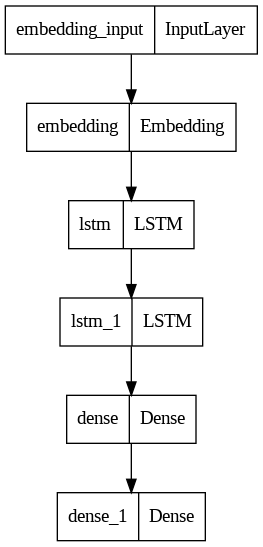

In [64]:
# visualizing the model
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [66]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [69]:
model.fit(x, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
309/309 [==============================] - ETA: 0s - loss: 6.3580
Epoch 1: loss improved from inf to 6.35800, saving model to nextword1.h5
309/309 [==============================] - 68s 219ms/step - loss: 6.3580 - lr: 0.0010
Epoch 2/150
309/309 [==============================] - ETA: 0s - loss: 6.1257
Epoch 2: loss improved from 6.35800 to 6.12570, saving model to nextword1.h5
309/309 [==============================] - 70s 226ms/step - loss: 6.1257 - lr: 0.0010
Epoch 3/150
309/309 [==============================] - ETA: 0s - loss: 5.8770
Epoch 3: loss improved from 6.12570 to 5.87699, saving model to nextword1.h5
309/309 [==============================] - 71s 230ms/step - loss: 5.8770 - lr: 0.0010
Epoch 4/150
309/309 [==============================] - ETA: 0s - loss: 5.6394
Epoch 4: loss improved from 5.87699 to 5.63936, saving model to nextword1.h5
309/309 [==============================] - 73s 235ms/step - loss: 5.6394 - lr: 0.0010
Epoch 5/150
309/309 [===================

#### Evaluating the model

In [113]:
# def next_word_pred(model, tokenizer, text):
#   encoded_txt = tokenizer.texts_to_sequences([text])[0]
#   encoded_txt = np.array(encoded_txt)

#   next_word_token_prob = model.predict(encoded_txt)
#   next_word_toekn_max_prob = np.argmax(next_word_token_prob)

#   for word, token in tokenizer.word_index.items():
#     if token == next_word_toekn_max_prob:
#         return word
  
#   return None


In [118]:
def next_word_pred(model, tokenizer, word_token):
  next_word_token_prob = model.predict(word_token)
  next_word_toekn_max_prob = np.argmax(next_word_token_prob)

  for word, token in tokenizer.word_index.items():
    if token == next_word_toekn_max_prob:
        return word
  
  return None

In [125]:
model.predict(51)

IndexError: ignored

In [127]:
y_pred = []
for word_token in x:
  print(word_token)
  next_word_token_prob, unk = model.predict([word_token])
  next_word_toekn_max_prob = np.argmax(next_word_token_prob)
  print(next_word_toekn_max_prob)
  y_pred.append(next_word_toekn_max_prob)

y_pred

51


ValueError: ignored

In [116]:
text = "dull"
next_word_pred(model, tokenizer, text)

1/1 [==============================] - 0s 22ms/step


'pain'

In [84]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'and': 3,
 'he': 4,
 'his': 5,
 'of': 6,
 'was': 7,
 'it': 8,
 'in': 9,
 'had': 10,
 'that': 11,
 'a': 12,
 'as': 13,
 'gregor': 14,
 'she': 15,
 'with': 16,
 'him': 17,
 'her': 18,
 'not': 19,
 'but': 20,
 'would': 21,
 'at': 22,
 'for': 23,
 'they': 24,
 'on': 25,
 'all': 26,
 'room': 27,
 'could': 28,
 'be': 29,
 'out': 30,
 'from': 31,
 'have': 32,
 'if': 33,
 'so': 34,
 'there': 35,
 'father': 36,
 'been': 37,
 'now': 38,
 'gregors': 39,
 'then': 40,
 'sister': 41,
 'this': 42,
 'mother': 43,
 'into': 44,
 'back': 45,
 'up': 46,
 'door': 47,
 'even': 48,
 'did': 49,
 'no': 50,
 'one': 51,
 'what': 52,
 'himself': 53,
 'were': 54,
 'when': 55,
 'more': 56,
 'about': 57,
 'them': 58,
 'their': 59,
 'way': 60,
 'i': 61,
 'time': 62,
 'only': 63,
 'said': 64,
 'by': 65,
 'than': 66,
 'you': 67,
 'little': 68,
 'get': 69,
 'just': 70,
 'other': 71,
 'first': 72,
 'any': 73,
 'or': 74,
 'much': 75,
 'go': 76,
 'do': 77,
 'still': 78,
 'head': 79,
 'made': 80,
 'whe